In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import regex
import os
import urllib
from bs4 import BeautifulSoup
from wordcloud import WordCloud
import gensim
from gensim.utils import lemmatize
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy #python3 -m spacy download it_core_news_sm
# import pyLDAvis
# import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
from spacy.lang.it.stop_words import STOP_WORDS as ita
import urllib
import sys


import urllib.request


In [ ]:
d = []
urls = pd.read_csv('/content/drive/My Drive/Research/Datasets/1352.csv')['0'].tolist()
for i in range(0,10000):
    if urls[i][0:2] == '//':
        urls[i] = urls[i][2:]
fp = urllib.request.urlopen('https://'+urls[0])
for url in urls:
    try:
        fp = urllib.request.urlopen('https://'+url)
        soup = BeautifulSoup(fp)
        d.append(
            {
                'Date': ", ".join([element.text.strip() for element in soup.find_all(class_='meta-part time')]),
                'Title': ", ".join([element.text.strip() for element in soup.find_all(class_='hlink hlink--page-title')]),
                'Article': ", ".join([element.text.strip() for element in soup.find_all(class_='atext')])

            }
        )
    except:
        continue
    print(d[-1])

In [ ]:
df = pd.DataFrame(d)
df['Date'] =pd.to_datetime(df.Date)
df =df.dropna().set_index('Date').sort_index()
texts = df.Article.values.tolist()

344

In [ ]:
#regular expression: formatting text
def formatting(texts):
    texts = [regex.sub('\s+', ' ', text) for text in texts] #remove new lines
    texts = [regex.sub("\"", "", text) for text in texts] #remove quotations
    texts = [regex.sub("\'", "", text) for text in texts] #remove quotations
    return texts
formatted_text = formatting(texts)
formatted_text[0]

<>:3: DeprecationWarning: invalid escape sequence \s
<>:3: DeprecationWarning: invalid escape sequence \s
<>:3: DeprecationWarning: invalid escape sequence \s
<ipython-input-6-8f393b3618c1>:3: DeprecationWarning: invalid escape sequence \s
  texts = [regex.sub('\s+', ' ', text) for text in texts] #remove new lines


'A pneumonia outbreak that has infected more than 50 people in the Chinese city of Wuhan was caused by a coronavirus, which is the same kind of pathogen involved in the deadly Sars outbreak in 2003, Chinese state media said on Thursday.The outbreak, which comes ahead of the lunar new year holidays in late January when millions of Chinese will be travelling to see their families, has caused alarm in the region. The virus has prompted widespread concern on Chinese social media and triggered memories of the 2003 outbreak of severe acute respiratory syndrome, or Sars, that infected more than 8,000 people worldwide and killed more than 700, including almost 300 in Hong Kong.The World Health Organization said, in a statement issued on Thursday, the Chinese authorities believed the disease “does not transmit readily between people”, but noted that it could cause severe illness in some patients.Chinese health officials said on Sunday that they had identified 59 cases, with seven patients in cr

In [ ]:
stop_words = list(en)
# url = "https://gist.githubusercontent.com/deekayen/4148741/raw/98d35708fa344717d8eee15d11987de6c8e26d7d/1-1000.txt"
# file = urllib.request.urlopen(url)
# stop_ext = [line.decode("utf-8").strip() for line in file]
# stop_words = stop_words + stop_ext
stop_words.extend(['per','bn','mr','cent','say','new'])
stop_words.extend(['use','per','not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])
lemma = spacy.load('en', disable=['parser', 'ner'])

def token(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence),deacc=True)) 

def bigram_trigram(texts):
    bigram = gensim.models.Phrases(formatted_text)
    trigram = gensim.models.Phrases(bigram[formatted_text])
    bigram_ = gensim.models.phrases.Phraser(bigram)
    trigram_ = gensim.models.phrases.Phraser(trigram)
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts] 
    bi = [bigram_[text] for text in texts]
    tri = [trigram_[bigram_[b]] for b in bi]
    return tri
def processing(texts, stop_words=stop_words):
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    output = []
    for text in texts:
        doc = lemma(" ".join(text)) 
        output.append([token.lemma_ for token in doc])
    # remove stopwords once more after lemmatization
    output = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in output]
    return output

tokens = list(token(formatted_text))
bi_tri = bigram_trigram(tokens)
final_data = processing(bi_tri)
df['ProcessedArticles'] = final_data

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(final_data)


# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in final_data]

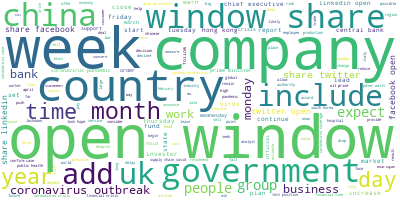

In [ ]:
data_to_string = ','.join([item for sublist in final_data for item in sublist])
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='red')
# Generate a word cloud
wordcloud.generate(data_to_string)
# Visualize the word cloud
wordcloud.to_image()

In [ ]:

# Build LDAmallet model
mallet_path = '/Users/pietroaluffi/Documents/Imperial/AP/mallet-2.0.8/bin/mallet'  
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

In [ ]:
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)
# pyLDAvis.gensim.prepare(model, corpus, id2word)

In [ ]:
# #takes long to run
# # Build LDA model
# lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
#                                            id2word=id2word,
#                                            num_topics=20, 
#                                            random_state=100,
#                                            update_every=1,
#                                            chunksize=100,
#                                            passes=10,
#                                            alpha='auto',
#                                            per_word_topics=True)
# pyLDAvis.enable_notebook()
# lda_visua = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
# lda_visua


In [ ]:
# pyLDAvis.save_html(lda_visua,'l.html')

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=2):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

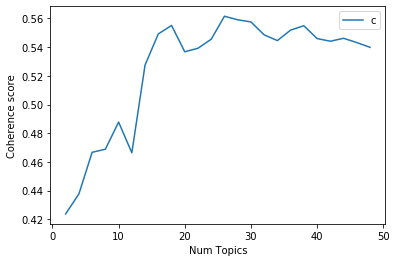

Num Topics = 2  has Coherence Value of 0.4238
Num Topics = 4  has Coherence Value of 0.4377
Num Topics = 6  has Coherence Value of 0.4667
Num Topics = 8  has Coherence Value of 0.4689
Num Topics = 10  has Coherence Value of 0.4877
Num Topics = 12  has Coherence Value of 0.4664
Num Topics = 14  has Coherence Value of 0.5275
Num Topics = 16  has Coherence Value of 0.5492
Num Topics = 18  has Coherence Value of 0.5551
Num Topics = 20  has Coherence Value of 0.5367
Num Topics = 22  has Coherence Value of 0.5392
Num Topics = 24  has Coherence Value of 0.5455
Num Topics = 26  has Coherence Value of 0.5615
Num Topics = 28  has Coherence Value of 0.559
Num Topics = 30  has Coherence Value of 0.5575
Num Topics = 32  has Coherence Value of 0.5485
Num Topics = 34  has Coherence Value of 0.5445
Num Topics = 36  has Coherence Value of 0.5519
Num Topics = 38  has Coherence Value of 0.5549
Num Topics = 40  has Coherence Value of 0.546
Num Topics = 42  has Coherence Value of 0.5441
Num Topics = 44  ha

In [ ]:

start_time = time.time()
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=final_data, start=2, limit=50, step=2)
print("--- %s seconds ---" % (time.time() - start_time))

# Show graph
limit=50; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [ ]:
optimal_model = model_list[8]
model_topics = optimal_model.show_topics(formatted=False)
pp.pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.027*"company" + 0.018*"supply" + 0.015*"chain" + 0.011*"production" + '
  '0.011*"store" + 0.011*"week" + 0.010*"food" + 0.009*"worker" + 0.009*"work" '
  '+ 0.009*"product"'),
 (1,
  '0.070*"share" + 0.069*"open" + 0.057*"window" + 0.023*"twitter" + '
  '0.021*"facebook" + 0.019*"linkedin" + 0.019*"coronavirus" + 0.013*"death" + '
  '0.010*"pandemic" + 0.009*"number"'),
 (2,
  '0.108*"coronavirus" + 0.037*"late" + 0.027*"spread" + 0.023*"outbreak" + '
  '0.020*"follow" + 0.017*"week" + 0.016*"business" + 0.016*"recommend" + '
  '0.016*"stay" + 0.015*"read"'),
 (3,
  '0.066*"bank" + 0.024*"rate" + 0.024*"market" + 0.022*"debt" + '
  '0.018*"central" + 0.015*"bond" + 0.015*"financial" + 0.014*"credit" + '
  '0.012*"loan" + 0.011*"interest"'),
 (4,
  '0.018*"eu" + 0.017*"crisis" + 0.017*"european" + 0.015*"airline" + '
  '0.015*"government" + 0.010*"france" + 0.010*"country" + 0.010*"europe" + '
  '0.010*"germany" + 0.009*"member"'),
 (5,
  '0.046*"price" + 0.042*"oil" + 0.017*

In [ ]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

#
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=final_data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
dom = df_dominant_topic['Dominant_Topic'].tolist()
df['Dominant_Topic'] = dom




In [ ]:
topics = ['topic0','topic1','topic2','topic3','topic4'] #,'topic5','topic6','topic7','topic8','topic9','topic10','topic11','topic12','topic13','topic14','topic15','topic16','topic17','topic18','topic19']
for i in range(20):
    
    topics[i] = df[df['Dominant_Topic'] == i]

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,11.0,0.5170,"china, outbreak, chinese, virus, kong, hong, c...","[pneumonia, outbreak, infect, people, chinese,..."
1,1,11.0,0.5334,"china, outbreak, chinese, virus, kong, hong, c...","[japan, confirm, case, newly, identify, virus,..."
2,2,11.0,0.3339,"china, outbreak, chinese, virus, kong, hong, c...","[concern, rise, outbreak, virus, originate, ch..."
3,3,11.0,0.5420,"china, outbreak, chinese, virus, kong, hong, c...","[china, national, health, commission, confirm,..."
4,4,11.0,0.3261,"china, outbreak, chinese, virus, kong, hong, c...","[china, battle, contain, outbreak, sars, like,..."
5,5,8.0,0.2664,"economy, year, economic, fall, growth, low, gl...","[european, stock, follow, asian, market, low, ..."
6,6,8.0,0.1351,"economy, year, economic, fall, growth, low, gl...","[stock, close, low, tuesday, report, case, cor..."
7,7,11.0,0.3726,"china, outbreak, chinese, virus, kong, hong, c...","[health, official, confirm, case, deadly, coro..."
8,8,11.0,0.4155,"china, outbreak, chinese, virus, kong, hong, c...","[chinese, authority, shut, transport, network,..."
9,9,11.0,0.3402,"china, outbreak, chinese, virus, kong, hong, c...","[share, asian, business, rubber, glove, surgic..."


In [ ]:

df['weekoftheyear'] = [week.weekofyear for week in df.index]
df['Dominant Topic'] = [b for b in df_dominant_topic['Dominant_Topic']]

In [ ]:
a = []
for i in range(2,15):
    week_data = df[(df['weekoftheyear'] == i)]['ProcessedArticles']

    data_to_string = ','.join([item for sublist in week_data for item in sublist])
    wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='red')
    # Generate a word cloud
    a.append(wordcloud.generate(data_to_string))
    # Visualize the word cloud


In [ ]:
print('WEEK 2')
a[0].to_image()

In [ ]:
print('WEEK 3')
a[1].to_image()

In [ ]:
print('WEEK 4')
a[2].to_image()

In [ ]:
print('WEEK 5')
a[3].to_image()

In [ ]:
print('WEEK 6')
a[4].to_image()

In [ ]:
print('WEEK 7')
a[5].to_image()

In [ ]:
print('WEEK 8')
a[6].to_image()

In [ ]:
print('WEEK 9')
a[7].to_image()

In [ ]:
print('WEEK 10')
a[8].to_image()

In [ ]:
print('WEEK 11')
a[9].to_image()

In [ ]:
print('WEEK 12')
a[10].to_image()

In [ ]:
print('WEEK 13')
a[11].to_image()

In [ ]:
print('WEEK 14')
a[12].to_image()

In [ ]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 4729.4968428611755 seconds ---


In [ ]:
model.save('lda_{}t_500p_autoalpha_val.model'.format(20))

In [ ]:
pp.pprint(optimal_model.show_topics(num_topics=-1, num_words=50, formatted=False))


[(0,
  [('company', 0.027289228265631845),
   ('supply', 0.018260624647931403),
   ('chain', 0.014802528634912687),
   ('production', 0.01137572760843713),
   ('week', 0.011125367716091883),
   ('store', 0.011125367716091883),
   ('food', 0.009826625774550917),
   ('worker', 0.009482380922576203),
   ('work', 0.009451085936033048),
   ('product', 0.008527883833009951),
   ('order', 0.00846529385992364),
   ('industry', 0.008402703886837328),
   ('sale', 0.008355761407022594),
   ('service', 0.008340113913751017),
   ('business', 0.008340113913751017),
   ('demand', 0.008293171433936283),
   ('online', 0.00808975402140577),
   ('car', 0.00801151655504788),
   ('delivery', 0.00794892658196157),
   ('plant', 0.0074951492770858105),
   ('home', 0.007088314452024786),
   ('close', 0.006540652187519559),
   ('customer', 0.006493709707704826),
   ('factory', 0.006493709707704826),
   ('retailer', 0.006399824748075359),
   ('supplier', 0.005977342429742755),
   ('large', 0.0059460474431996),
 

In [ ]:
topics = {
    0: 'Production/Supply_Chain',
    1: 'Social_Media',
    2: 'Media_Coverage',
    3: 'Banking/Central_Banks',
    4: 'EU_Outbreak/Airlines',
    5: 'Oil_Energy',
    6: 'UK_Outbreak',
    7: 'Vaccine/Research',
    8: 'Global_Economy',
    9: 'UK_Economic_Measures',
    10: 'France',
    11: 'China/Wuhan_Outbreak',
    12: 'United_States/Election',
    13: 'Corporations',
    14: 'Global_Outbreak',
    15: 'UK_Businesses',
    16: 'Global_Lockdown',
    17: 'Investments'
}

In [ ]:
global_economy = model.show_topics(num_topics=-1, num_words=50)[0][1].split()

In [ ]:
global_economy = model.show_topics(num_topics=-1, num_words=50)[0][1].split()
global_economy_words = []
for word in np.arange(0,len(global_economy))[::2]:
    global_economy_words.append(int(float(global_economy[word].split('*')[0])*1000)*[global_economy[word].split('*')[1].split('"')[1]])

In [ ]:
def get_words(topic,model,i):
    topic = model.show_topics(num_topics=-1, num_words=50)[i][1].split()
    topic_words = []
    for word in np.arange(0,len(topic))[::2]:
        topic_words.append(int(float(topic[word].split('*')[0])*1000)*[topic[word].split('*')[1].split('"')[1]])
    return topic_words

In [ ]:
topic_words = []
for topic in topics:
    topic_words.append(str(topics[topic])+'_words')

In [ ]:
for i in range(len(topic_words)):
    topic_words[i] = get_words(topic,optimal_model,i)

In [ ]:



art_topics = []
for article in corpus:
    art_topics.append(model.get_document_topics(article, 
                                           minimum_probability=0.13,   
                                                   # minprob will need to be adjusted based on no of topics generated by the model!
                                           minimum_phi_value=None, 
                                           per_word_topics=False)
#               .sort(key=itemgetter(1),reverse=True)
             )


In [ ]:
df['Topics'] = art_topics
df.columns

Index(['Article', 'Title', 'ProcessedArticles', 'Dominant_Topic', 'Topics'], dtype='object')

In [ ]:
for t in np.arange(0,16):
    df[topics[t]] = [[i[1] if i[0]==t else 0 for i in a] for a in df['Topics']]
    df[topics[t]] = [[i for i in a if i > 0] for a in df[topics[t]]]
    df[topics[t]] = df[topics[t]].apply(lambda x: 0 if len(x)==0 else x[0])

In [ ]:
df.sort_values(by='Date',inplace=True)

In [ ]:
day_strength = df.drop(['Article','Title','Dominant_Topic','Topics'],axis=1).groupby('Date').sum()


# day_strength






In [ ]:
day_strength.reset_index(inplace=True)

In [ ]:
day_strength['Total'] = day_strength.sum(axis=1)

In [ ]:
day_strength.to_csv('tableau_years_strength_final.csv')

In [ ]:
day_strength = day_strength.drop(['Total'],axis=1)

In [ ]:
day_strength

,Date,Production/Supply_Chain,Social_Media,Media_Coverage,Banking/Central_Banks,EU_Outbreak/Airlines,Oil_Energy,UK_Outbreak,Vaccine/Research,Global_Economy,UK_Economic_Measures,France,China/Wuhan_Outbreak,United_States/Election,Corporations,Global_Outbreak,UK_Businesses
0,2020-01-09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.521248,0.000000,0.000000,0.000000,0.000000
1,2020-01-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.541437,0.000000,0.000000,0.000000,0.000000
2,2020-01-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.163111,0.187816,0.000000,0.000000,0.000000,0.340089,0.000000,0.000000,0.000000,0.000000
3,2020-01-20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.534253,0.000000,0.000000,0.000000,0.000000
4,2020-01-21,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.418255,0.000000,0.000000,0.322533,0.000000,0.000000,0.315310,0.000000
5,2020-01-22,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.119197,0.000000,0.000000,0.192204,0.000000
6,2020-01-23,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.216424,0.000000,0.000000,0.291835,0.000000,0.000000,0.000000,0.000000
7,2020-01-24,0.294854,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.967730,0.000000,0.427311,0.000000,0.000000
8,2020-01-25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.350203,0.000000,0.000000,0.132021,0.000000
9,2020-01-26,0.000000,0.000000,0.000000,0.176971,0.000000,0.000000,0.000000,0.000000,0.180663,0.000000,0.000000,0.808767,0.000000,0.135203,0.000000,0.000000


In [ ]:
day_strength = day_strength.set_index('Date')
res = day_strength.div(day_strength.sum(axis=1), axis=0)

In [ ]:
res.to_csv('tableau_years_strength_final.csv')

In [ ]:
r